# Power Outages
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the severity (number of customers, duration, or demand loss) of a major power outage.
    * Predict the cause of a major power outage.
    * Predict the number and/or severity of major power outages in the year 2020.
    * Predict the electricity consumption of an area.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
TODO

### Baseline Model
TODO

### Final Model
TODO

### Fairness Evaluation
TODO

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import datetime
from IPython.display import display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [292]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_excel('outage.xlsx', skiprows = 5)
df = df.drop(0).drop(['variables','OBS'], axis = 1).reset_index(drop=True)
df

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,2011-07-03 00:00:00,20:00:00,severe weather,NaN,NaN,3060,NaN,70000.0,11.6,9.18,6.81,9.28,2332915,2114774,2113291,6562520,35.5491,32.225,32.2024,2308736.0,276286.0,10673.0,2595696.0,88.9448,10.644,0.411181,51268,47586,1.07738,1.6,4802,274182,1.75139,2.2,5348119.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
1,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,2014-05-11 00:00:00,18:39:00,intentional attack,vandalism,NaN,1,NaN,NaN,12.12,9.71,6.49,9.28,1586986,1807756,1887927,5284231,30.0325,34.2104,35.7276,2345860.0,284978.0,9898.0,2640737.0,88.8335,10.7916,0.37482,53499,49091,1.08979,1.9,5226,291955,1.79,2.2,5457125.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
2,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,2010-10-28 00:00:00,22:00:00,severe weather,heavy wind,NaN,3000,NaN,70000.0,10.87,8.19,6.07,8.15,1467293,1801683,1951295,5222116,28.0977,34.501,37.366,2300291.0,276463.0,10150.0,2586905.0,88.9206,10.687,0.392361,50447,47287,1.06683,2.7,4571,267895,1.70627,2.1,5310903.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
3,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,2012-06-20 00:00:00,23:00:00,severe weather,thunderstorm,NaN,2550,NaN,68200.0,11.79,9.25,6.71,9.19,1851519,1941174,1993026,5787064,31.9941,33.5433,34.4393,2317336.0,278466.0,11010.0,2606813.0,88.8954,10.6822,0.422355,51598,48156,1.07148,0.6,5364,277627,1.93209,2.2,5380443.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
4,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,2015-07-19 00:00:00,07:00:00,severe weather,NaN,NaN,1740,250,250000.0,13.07,10.16,7.74,10.43,2028875,2161612,1777937,5970339,33.9826,36.2059,29.7795,2374674.0,289044.0,9812.0,2673531.0,88.8216,10.8113,0.367005,54431,49844,1.09203,1.7,4873,292023,1.6687,2.2,5489594.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,2011.0,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,2011-12-06 00:00:00,08:00:00,2011-12-06 00:00:00,20:00:00,public appeal,NaN,NaN,720,155,34500.0,8.41,7.8,6.2,7.56,488853,438133,386693,1313678,37.2125,33.3516,29.4359,330738.0,60017.0,3639.0,394394.0,83.8598,15.2175,0.922681,57012,47586,1.19808,9.8,934,39067,2.39076,0.5,685326.0,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.5996,2.40177,2.40177
1530,2006.0,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,NaN,NaN,NaN,NaN,fuel supply emergency,Coal,NaN,NaN,1650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,309997.0,53709.0,2331.0,366037.0,84.6901,14.6731,0.636821,42913,48909,0.877405,3.5,1019,27868,3.65652,0.7,649422.0,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.5996,2.40177,2.40177
1531,2009.0,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,2009-08-29 00:00:00,22:54:00,2009-08-29 00:00:00,23:53:00,islanding,NaN,NaN,59,84,NaN,9.25,7.47,5.53,7.67,337874,370771,

In [4]:
start_time = pd.to_datetime(
    df['OUTAGE.START.DATE'].dropna().astype(str).str.split(' ').str[0] 
    + ' ' 
    + df['OUTAGE.START.TIME'].dropna().astype(str)
)

restoration_time = pd.to_datetime(
    df['OUTAGE.RESTORATION.DATE'].dropna().astype(str).str.split(' ').str[0] 
    + ' ' 
    + df['OUTAGE.RESTORATION.TIME'].dropna().astype(str)
)

In [5]:
df['OUTAGE.RESTORATION'] = restoration_time
df['OUTAGE.START'] = start_time
df = df.drop(['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'], axis = 1)
df

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,HURRICANE.NAMES,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,RES.PERCEN,COM.PERCEN,IND.PERCEN,RES.CUSTOMERS,COM.CUSTOMERS,IND.CUSTOMERS,TOTAL.CUSTOMERS,RES.CUST.PCT,COM.CUST.PCT,IND.CUST.PCT,PC.REALGSP.STATE,PC.REALGSP.USA,PC.REALGSP.REL,PC.REALGSP.CHANGE,UTIL.REALGSP,TOTAL.REALGSP,UTIL.CONTRI,PI.UTIL.OFUSA,POPULATION,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.RESTORATION,OUTAGE.START
0,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,NaN,NaN,3060,NaN,70000.0,11.6,9.18,6.81,9.28,2332915,2114774,2113291,6562520,35.5491,32.225,32.2024,2308736.0,276286.0,10673.0,2595696.0,88.9448,10.644,0.411181,51268,47586,1.07738,1.6,4802,274182,1.75139,2.2,5348119.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2011-07-03 20:00:00,2011-07-01 17:00:00
1,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,intentional attack,vandalism,NaN,1,NaN,NaN,12.12,9.71,6.49,9.28,1586986,1807756,1887927,5284231,30.0325,34.2104,35.7276,2345860.0,284978.0,9898.0,2640737.0,88.8335,10.7916,0.37482,53499,49091,1.08979,1.9,5226,291955,1.79,2.2,5457125.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2014-05-11 18:39:00,2014-05-11 18:38:00
2,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,heavy wind,NaN,3000,NaN,70000.0,10.87,8.19,6.07,8.15,1467293,1801683,1951295,5222116,28.0977,34.501,37.366,2300291.0,276463.0,10150.0,2586905.0,88.9206,10.687,0.392361,50447,47287,1.06683,2.7,4571,267895,1.70627,2.1,5310903.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2010-10-28 22:00:00,2010-10-26 20:00:00
3,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,severe weather,thunderstorm,NaN,2550,NaN,68200.0,11.79,9.25,6.71,9.19,1851519,1941174,1993026,5787064,31.9941,33.5433,34.4393,2317336.0,278466.0,11010.0,2606813.0,88.8954,10.6822,0.422355,51598,48156,1.07148,0.6,5364,277627,1.93209,2.2,5380443.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2012-06-20 23:00:00,2012-06-19 04:30:00
4,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,severe weather,NaN,NaN,1740,250,250000.0,13.07,10.16,7.74,10.43,2028875,2161612,1777937,5970339,33.9826,36.2059,29.7795,2374674.0,289044.0,9812.0,2673531.0,88.8216,10.8113,0.367005,54431,49844,1.09203,1.7,4873,292023,1.6687,2.2,5489594.0,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874,2015-07-19 07:00:00,2015-07-18 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,2011.0,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,public appeal,NaN,NaN,720,155,34500.0,8.41,7.8,6.2,7.56,488853,438133,386693,1313678,37.2125,33.3516,29.4359,330738.0,60017.0,3639.0,394394.0,83.8598,15.2175,0.922681,57012,47586,1.19808,9.8,934,39067,2.39076,0.5,685326.0,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.5996,2.40177,2.40177,2011-12-06 20:00:00,2011-12-06 08:00:00
1530,2006.0,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,fuel supply emergency,Coal,NaN,NaN,1650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,309997.0,53709.0,2331.0,366037.0,84.6901,14.6731,0.636821,42913,48909,0.877405,3.5,1019,27868,3.65652,0.7,649422.0,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.5996,2.40177,2.40177,NaT,NaT
1531,2009.0,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,islanding,NaN,NaN,59,84,NaN,9.25,7.47,5.53,7.67,337874,370771,215406,924051,36.5644,40.1245,23.3111,367206.0,65971.0,3052.0,436229.0,84.1773,15.123,0.699633,45230,46680,0.968937,0,606,36504,1.66009,0.3,807067.0,56.65,26.73,2038.3,1905.4,4.7,0.3,0.15,98.3077,1.69226,1.69226,2009-08-29 23:53:00,20

In [7]:
df['CAUSE.CATEGORY'].value_counts()

severe weather                   763
intentional attack               418
system operability disruption    127
public appeal                     69
equipment failure                 60
fuel supply emergency             51
islanding                         46
Name: CAUSE.CATEGORY, dtype: int64

0

### Baseline Model

In [14]:
# TODO
# Y: CUSTOMERS.AFFECTED
# X: YEAR, U.S._STATE, CAUSE.CATEGORY, DURATION, POPULATION

In [289]:
from sklearn.preprocessing import Binarizer

In [264]:
ndf = df[['YEAR', 'U.S._STATE', 'CAUSE.CATEGORY', 'OUTAGE.DURATION', 'POPULATION', 'CUSTOMERS.AFFECTED', 'TOTAL.CUSTOMERS']]
ndf = ndf.dropna()
ndf

,YEAR,U.S._STATE,CAUSE.CATEGORY,OUTAGE.DURATION,POPULATION,CUSTOMERS.AFFECTED,TOTAL.CUSTOMERS
0,2011.0,Minnesota,severe weather,3060,5348119.0,70000.0,2595696.0
2,2010.0,Minnesota,severe weather,3000,5310903.0,70000.0,2586905.0
3,2012.0,Minnesota,severe weather,2550,5380443.0,68200.0,2606813.0
4,2015.0,Minnesota,severe weather,1740,5489594.0,250000.0,2673531.0
5,2010.0,Minnesota,severe weather,1860,5310903.0,60000.0,2586905.0
...,...,...,...,...,...,...,...
1522,2004.0,Idaho,system operability disruption,95,1391802.0,35000.0,701140.0
1523,2011.0,Idaho,intentional attack,360,1584134.0,0.0,794925.0
1524,2003.0,Idaho,public appeal,1548,1363380.0,0.0,687334.0
1526,2016.0,Idaho,intentional attack,0,1680026.0,0.0,849763.0


In [265]:
X = ndf[['YEAR', 'U.S._STATE', 'CAUSE.CATEGORY', 'OUTAGE.DURATION', 'POPULATION', 'TOTAL.CUSTOMERS']]
y = ndf['CUSTOMERS.AFFECTED']

In [290]:
y

0        70000.0
2        70000.0
3        68200.0
4       250000.0
5        60000.0
          ...   
1522     35000.0
1523         0.0
1524         0.0
1526         0.0
1529     34500.0
Name: CUSTOMERS.AFFECTED, Length: 1056, dtype: float64

In [ ]:
y = Binarizer

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [279]:
X_train.isna().sum(axis=0)

YEAR               0
U.S._STATE         0
CAUSE.CATEGORY     0
OUTAGE.DURATION    0
POPULATION         0
TOTAL.CUSTOMERS    0
dtype: int64

In [280]:
cat = ['YEAR', 'U.S._STATE', 'CAUSE.CATEGORY']
num = ['OUTAGE.DURATION', 'TOTAL.CUSTOMERS']

cat_func = OneHotEncoder(handle_unknown='ignore')
num_func = FunctionTransformer(lambda x:x)

ct = ColumnTransformer([('categorical', cat_func, cat), ('numerical', num_func, num)])

In [285]:
baseline_pl = Pipeline([('column', ct), ('linear_regression', LinearRegression())])

In [286]:
baseline_pl.fit(X_train, y_train)

Pipeline(steps=[('column',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['YEAR', 'U.S._STATE',
                                                   'CAUSE.CATEGORY']),
                                                 ('numerical',
                                                  FunctionTransformer(func=<function <lambda> at 0x000001FEDD207EE0>),
                                                  ['OUTAGE.DURATION',
                                                   'TOTAL.CUSTOMERS'])])),
                ('linear_regression', LinearRegression())])

In [287]:
baseline_pl.score(X_train, y_train)

0.13883124545159575

In [288]:
baseline_pl.score(X_test, y_test)

0.11902951117496707

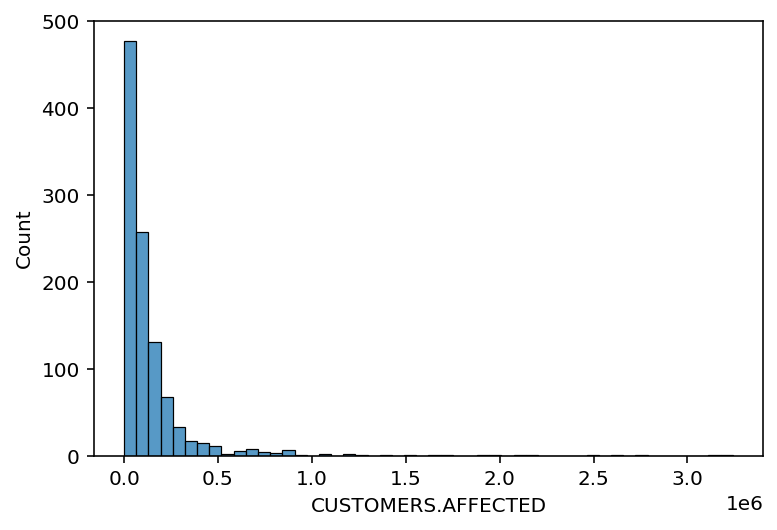

In [218]:
sns.histplot(y, bins=50)

In [169]:
np.median(y)

71661.5

In [291]:
ndf = df[['YEAR', 'U.S._STATE', 'CAUSE.CATEGORY', 'OUTAGE.DURATION', 'POPULATION', 'CUSTOMERS.AFFECTED', 'TOTAL.CUSTOMERS']]
ndf = ndf.dropna()
ndf

,YEAR,U.S._STATE,CAUSE.CATEGORY,OUTAGE.DURATION,POPULATION,CUSTOMERS.AFFECTED,TOTAL.CUSTOMERS
0,2011.0,Minnesota,severe weather,3060,5348119.0,70000.0,2595696.0
2,2010.0,Minnesota,severe weather,3000,5310903.0,70000.0,2586905.0
3,2012.0,Minnesota,severe weather,2550,5380443.0,68200.0,2606813.0
4,2015.0,Minnesota,severe weather,1740,5489594.0,250000.0,2673531.0
5,2010.0,Minnesota,severe weather,1860,5310903.0,60000.0,2586905.0
...,...,...,...,...,...,...,...
1522,2004.0,Idaho,system operability disruption,95,1391802.0,35000.0,701140.0
1523,2011.0,Idaho,intentional attack,360,1584134.0,0.0,794925.0
1524,2003.0,Idaho,public appeal,1548,1363380.0,0.0,687334.0
1526,2016.0,Idaho,intentional attack,0,1680026.0,0.0,849763.0


In [297]:
X = ndf[['YEAR', 'U.S._STATE', 'CUSTOMERS.AFFECTED', 'OUTAGE.DURATION', 'POPULATION', 'TOTAL.CUSTOMERS']]
y = ndf['CAUSE.CATEGORY']

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [302]:
cat = ['YEAR', 'U.S._STATE']
num = ['OUTAGE.DURATION', 'TOTAL.CUSTOMERS', 'CUSTOMERS.AFFECTED']

cat_func = OneHotEncoder(handle_unknown='ignore')
num_func = FunctionTransformer(lambda x:x)

ct = ColumnTransformer([('categorical', cat_func, cat), ('numerical', num_func, num)])

In [303]:
baseline_pl = Pipeline([('column', ct), ('dtc', (DecisionTreeClassifier(max_depth=20)))])

In [304]:
baseline_pl.fit(X_train, y_train)

Pipeline(steps=[('column',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['YEAR', 'U.S._STATE']),
                                                 ('numerical',
                                                  FunctionTransformer(func=<function <lambda> at 0x000001FEDCE62700>),
                                                  ['OUTAGE.DURATION',
                                                   'TOTAL.CUSTOMERS',
                                                   'CUSTOMERS.AFFECTED'])])),
                ('dtc', DecisionTreeClassifier(max_depth=20))])

In [ ]:
baseline_pl.score(X_train, y_train)

In [ ]:
baseline_pl.score(X_test, y_test)

### Final Model

In [ ]:
# TODO

### Fairness Evaluation

In [ ]:
# TODO